### Importing libraries & data.

In [150]:
import pandas as pd
from matplotlib import pyplot as plt
from numpy.polynomial.chebyshev import Chebyshev
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.patches as mpatches
import numpy as np
import constants

### Importing data
data = pd.read_csv("data/fsigma8_data.dat", sep=';', header=0)
z_data = data['z']
fs8_data = data['fsig8']
fs8_err_plus = data['fsig8_err_plus']
fs8_err_minus = data['fsig8_err_minus']
fs8_err = [fs8_err_plus, fs8_err_minus]

### Do we save the plots ?
SAVEFIG = False

### Defining functions.

In [151]:
### Defining functions for theoretical comparison
def omega_m(z, omega_0):
    return omega_0 * (1+z)**3 / (omega_0 * (1+z)**3 + 1 - omega_0)

def g(z, omega_0, omega_l0=0.7):
    omz = omega_m(z, omega_0)
    olz = 1 - omz
    return 2.5 * omz / (omz**(4/7) - olz + (1 + omz/2)*(1 + olz/70))

def D(z, omega_0, omega_l0=0.7):
    return g(z, omega_0, omega_l0) / g(0, omega_0, omega_l0) / (1 + z)

def gamma(omega_m_z):
    return 6/11 - 15/2057 * np.log(omega_m_z)

def sigma_8(z, omega_0, sigma_8_0):
    return sigma_8_0 * D(z, omega_0)

def f(gamma_func, z, omega_0):
    omega_m_z = omega_m(z, omega_0)
    return omega_m_z ** gamma_func(omega_m_z)

def growth(z, gamma_func = gamma, omega_0 = constants.OMEGA_0, sigma_8_0 = constants.SIGMA_8_0):
    """Returns linear growth rate according to the redshift.

    Args:
        z (float): redshift
        fun_gamma (γ): gamma. Defaults to gamma.
        omega_0 (float): Ωm(0). Defaults to constants.OMEGA_0.
        sigma_8_0 (float): σ8(0). Defaults to constants.SIGMA_8_0.

    Returns:
        float: fσ8(z)
    """
    return f(gamma_func, z, omega_0) * sigma_8(z, omega_0, sigma_8_0)

### Plotting growth data.

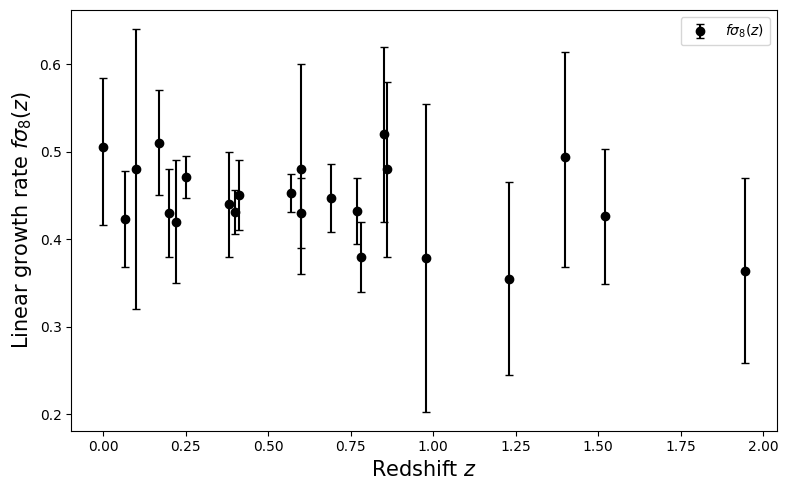

In [62]:
plt.figure(figsize=(8, 5))

plt.errorbar(z_data, fs8_data, yerr=fs8_err, fmt='o', color='black', label=r"$f\sigma_8(z)$", capsize=3)

plt.xlabel("Redshift $z$", fontsize=15)
plt.ylabel(r"Linear growth rate $f\sigma_8(z)$", fontsize=15)
plt.grid(False)
plt.legend()

plt.tight_layout()
if SAVEFIG:
    plt.savefig("figure1.png", dpi=300)

plt.show()

### Plotting theoretical linear growth rate with $3\sigma$ bootstrap envelope.

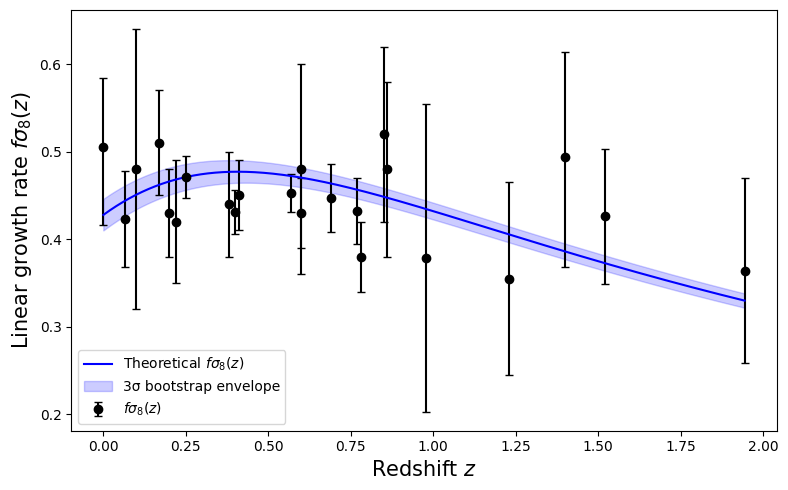

In [63]:
### Number of points for theoretical growth function plot
nb_points_th = 1000
z_range = np.linspace(min(z_data), max(z_data), nb_points_th)

### Bootstrap
nb_draw = 1000
fsigma8_results_boot = np.zeros((nb_draw, nb_points_th))

for i in range(nb_draw):
    omega_0 = np.random.normal(constants.OMEGA_0, constants.OMEGA_0_SIGMA)
    sigma_8_0 = np.random.normal(constants.SIGMA_8_0, constants.SIGMA_8_0_SIGMA)
    fsigma8_results_boot[i, :] = growth(z_range, omega_0, sigma_8_0)

fsigma8_mean, fsigma8_std = np.mean(fsigma8_results_boot, axis=0), np.std(fsigma8_results_boot, axis=0)


### Plotting
plt.figure(figsize=(8, 5))
# Data distribution
plt.errorbar(z_data, fs8_data, yerr=fs8_err, fmt='o', color='black', label=r"$f\sigma_8(z)$", capsize=3)
# Theoretical function
growth_values = growth(z_range)
plt.plot(z_range, growth_values, color='blue', label=r"Theoretical $f\sigma_8(z)$")
# Enveloppe
plt.fill_between(z_range, fsigma8_mean-3*fsigma8_std, fsigma8_mean+3*fsigma8_std, color='blue', alpha=0.2, label='3σ bootstrap envelope')
# Labels
plt.xlabel("Redshift $z$", fontsize=15)
plt.ylabel(r"Linear growth rate $f\sigma_8(z)$", fontsize=15)
plt.grid(False)
plt.legend()
plt.tight_layout()

if SAVEFIG:
    plt.savefig("figure2.png", dpi=300)

plt.show()

### Plotting theoretical $f\sigma_8(z)$ and polynomial approximations.

/tmp/ipykernel_2294/1407967706.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('OrRd')


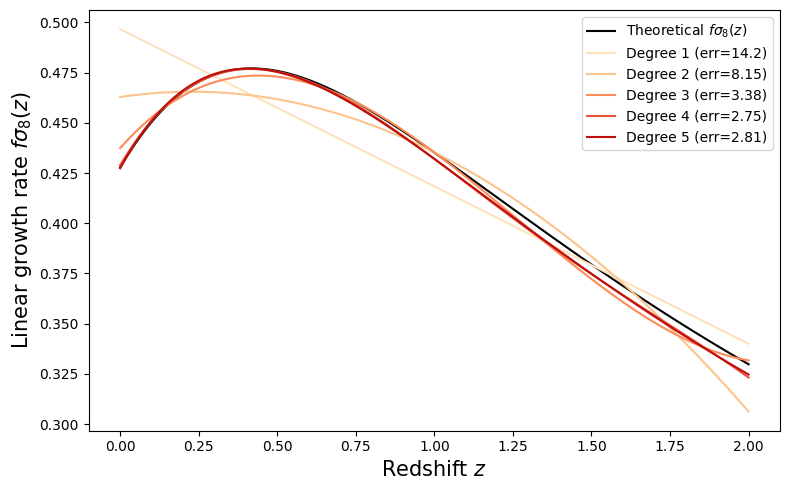

In [64]:
### Max polynomial degree
N = 5
domain = [0, 2]
z_dense = np.linspace(domain[0], domain[1], nb_points_th)
f_dense = growth(z_dense)

plt.figure(figsize=(8, 5))
plt.plot(z_dense, growth_values, color='black', label=r"Theoretical $f\sigma_8(z)$")

### For colors
norm = Normalize(vmin=0, vmax=N+1)
cmap = cm.get_cmap('OrRd')

for n in range(1, N+1):
    cheb_poly = Chebyshev.fit(z_dense, f_dense, deg=n, domain=domain)

    err = 0
    for i in range(nb_points_th):
        err += abs(cheb_poly(z_dense[i]) - growth_values[i])
    
    color = cmap(norm(n))
    plt.plot(z_dense, cheb_poly(z_dense),
             color=color,
             label=f'Degree {n} (err={round(err, 2)})')

plt.xlabel("Redshift $z$", fontsize=15)
plt.ylabel(r"Linear growth rate $f\sigma_8(z)$", fontsize=15)
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()

if SAVEFIG:
    plt.savefig("figure3.png", dpi=300)

### Plotting $(\sigma_8, \Omega_m)$ distribution.

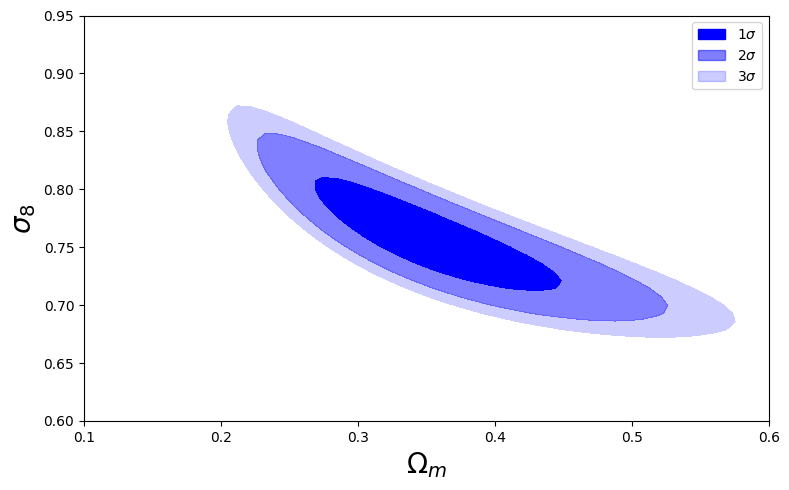

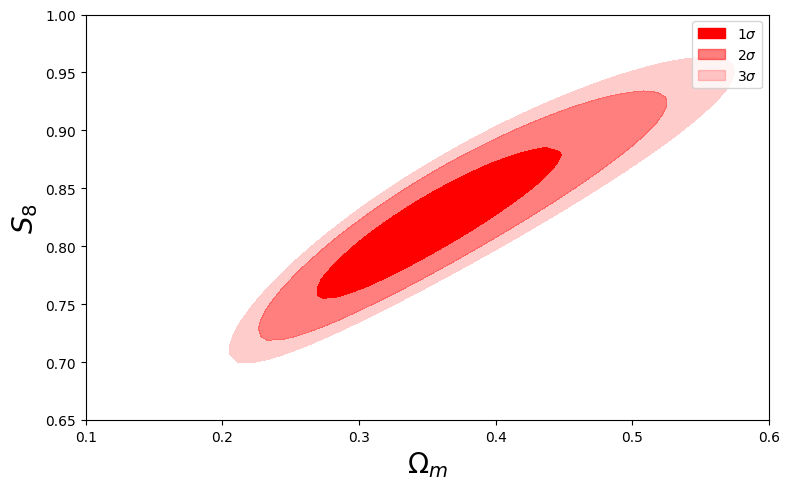

In [107]:
def calc_chi2_omega_sigma(omega0, sigma8_0):
    errors = 0.5 * (fs8_err_plus + fs8_err_minus)
    return np.sum((growth(z_data.values, omega_0=omega0, sigma_8_0=sigma8_0) - fs8_data)**2 / errors**2)


nb_points_distrib = 50
omega_m_list = np.linspace(0.1, 0.6, nb_points_distrib)
sigma_8_list = np.linspace(0.6, 0.95, nb_points_distrib)
s_8_list = np.linspace(0.65, 1.0, nb_points_distrib)

chi2_grid_plot1 = np.zeros((nb_points_distrib, nb_points_distrib))
chi2_grid_plot2 = np.zeros((nb_points_distrib, nb_points_distrib))

for i, omegam in enumerate(omega_m_list):
    for j, sigma8 in enumerate(sigma_8_list):
        chi2_grid_plot1[i, j] = calc_chi2_omega_sigma(omegam, sigma8)
    for j, s8 in enumerate(s_8_list):
        sigma8 = s8 * np.sqrt(0.3/omegam)
        chi2_grid_plot2[i, j] = calc_chi2_omega_sigma(omegam, sigma8)
        
delta_chi2_grid_plot1 = chi2_grid_plot1 - np.min(chi2_grid_plot1)
delta_chi2_grid_plot2 = chi2_grid_plot2 - np.min(chi2_grid_plot2)

levels = [2.30, 6.18, 9.21]

# Confidence Contour plot 1
plt.figure(figsize=(8, 5))

plt.contourf(omega_m_list, sigma_8_list, delta_chi2_grid_plot1.T, levels=[0, levels[0]], colors=['blue'], alpha=1.0)  # Bleu avec 100% d'opacité
plt.contourf(omega_m_list, sigma_8_list, delta_chi2_grid_plot1.T, levels=[levels[0], levels[1]], colors=['blue'], alpha=0.5)   # Rouge avec 80% d'opacité
plt.contourf(omega_m_list, sigma_8_list, delta_chi2_grid_plot1.T, levels=[levels[1], levels[2]], colors=['blue'], alpha=0.2)  # Noir avec 50% d'opacité

patch1 = mpatches.Patch(color='blue', alpha=1.0, label=r"1$\sigma$")
patch2 = mpatches.Patch(color='blue', alpha=0.5, label=r"2$\sigma$")
patch3 = mpatches.Patch(color='blue', alpha=0.2, label=r"3$\sigma$")

plt.xlabel(r"$\Omega_m$", fontsize=20)
plt.ylabel(r"$\sigma_8$", fontsize=20)
plt.grid(False)
plt.tight_layout()
plt.legend(handles=[patch1, patch2, patch3])
plt.show()

if SAVEFIG:
    plt.savefig("figure4.png", dpi=300)

# Confidence Contour plot 2
plt.figure(figsize=(8, 5))

plt.contourf(omega_m_list, s_8_list, delta_chi2_grid_plot2.T, levels=[0, levels[0]], colors=['red'], alpha=1.0)           # Bleu avec 100% d'opacité
plt.contourf(omega_m_list, s_8_list, delta_chi2_grid_plot2.T, levels=[levels[0], levels[1]], colors=['red'], alpha=0.5)   # Rouge avec 80% d'opacité
plt.contourf(omega_m_list, s_8_list, delta_chi2_grid_plot2.T, levels=[levels[1], levels[2]], colors=['red'], alpha=0.2)   # Noir avec 50% d'opacité

patch1 = mpatches.Patch(color='red', alpha=1.0, label=r"1$\sigma$")
patch2 = mpatches.Patch(color='red', alpha=0.5, label=r"2$\sigma$")
patch3 = mpatches.Patch(color='red', alpha=0.2, label=r"3$\sigma$")

plt.xlabel(r"$\Omega_m$", fontsize=20)
plt.ylabel(r"$S_8$", fontsize=20)
plt.grid(False)
plt.tight_layout()
plt.legend(handles=[patch1, patch2, patch3])
plt.show()

if SAVEFIG:
    plt.savefig("figure5.png", dpi=300)

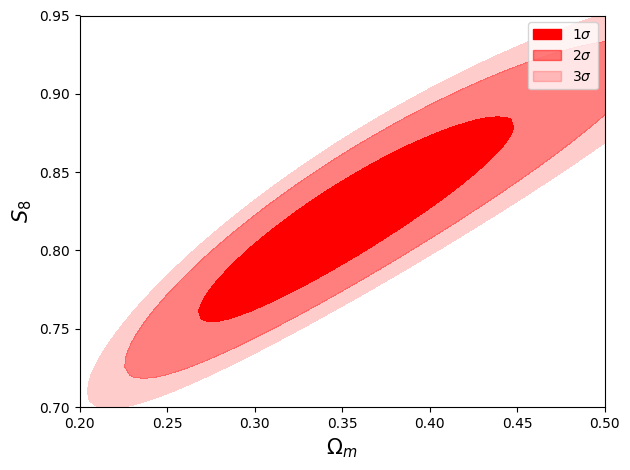

In [73]:
nb_points_distrib = 50

omega_m_list = np.linspace(0.2, 0.5, nb_points_distrib)
s_8_list = np.linspace(0.7, 0.95, nb_points_distrib)

chi2_grid = np.zeros((nb_points_distrib, nb_points_distrib))


for i, omegam in enumerate(omega_m_list):
    for j, s8 in enumerate(s_8_list):
        sigma8 = s8 * np.sqrt(0.3/omegam)
        chi2_grid[i, j] = calc_chi2_omega_sigma(omegam, sigma8)
        
delta_chi2_grid = chi2_grid - np.min(chi2_grid)

levels = [2.30, 6.18, 9.21]

# Confidence Contour plot
plt.contourf(omega_m_list, s_8_list, delta_chi2_grid.T, levels=[0, levels[0]], colors=['red'], alpha=1.0)           # Bleu avec 100% d'opacité
plt.contourf(omega_m_list, s_8_list, delta_chi2_grid.T, levels=[levels[0], levels[1]], colors=['red'], alpha=0.5)   # Rouge avec 80% d'opacité
plt.contourf(omega_m_list, s_8_list, delta_chi2_grid.T, levels=[levels[1], levels[2]], colors=['red'], alpha=0.2)   # Noir avec 50% d'opacité

patch1 = mpatches.Patch(color='red', alpha=1.0, label=r"1$\sigma$")
patch2 = mpatches.Patch(color='red', alpha=0.5, label=r"2$\sigma$")
patch3 = mpatches.Patch(color='red', alpha=0.2, label=r"3$\sigma$")

plt.xlabel(r"$\Omega_m$", fontsize=15)
plt.ylabel(r"$S_8$", fontsize=15)
plt.grid(False)
plt.tight_layout()
plt.legend(handles=[patch1, patch2, patch3])
plt.show()

if SAVEFIG:
    plt.savefig("figure5.png", dpi=300)

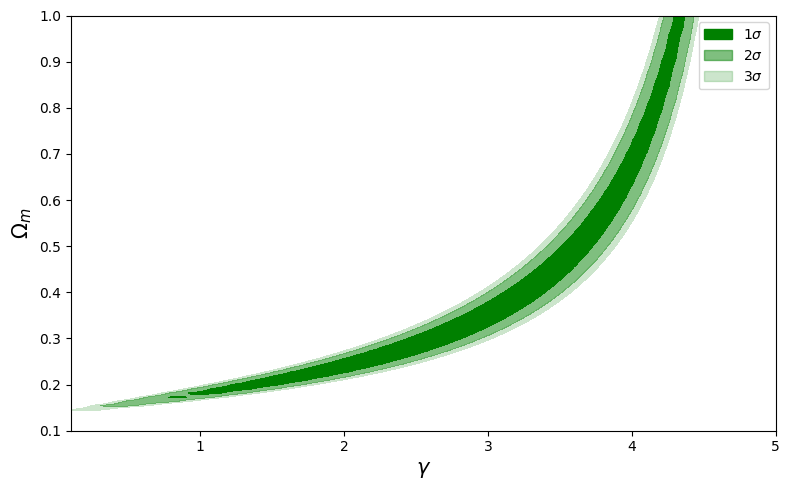

In [131]:
def calc_chi2_omega_gamma(omega_0, gamma_func):
    errors = 0.5 * (fs8_err_plus + fs8_err_minus)
    return np.sum((growth(z_data.values, gamma_func, omega_0) - fs8_data)**2 / errors**2)

nb_points_distrib = 100

omega_m_list = np.linspace(0.1, 1, nb_points_distrib)
gamma_list = np.linspace(0.1, 5, nb_points_distrib)

chi2_grid_plot1 = np.zeros((nb_points_distrib, nb_points_distrib))
chi2_grid_plot2 = np.zeros((nb_points_distrib, nb_points_distrib))

for j, gamma_func in enumerate(gamma_list):
    for i, omegam in enumerate(omega_m_list):
        chi2_grid_plot1[i, j] = calc_chi2_omega_gamma(omegam, lambda x : gamma_func)

delta_chi2_grid_plot1 = chi2_grid_plot1 - np.min(chi2_grid_plot1)

levels = [2.30, 6.18, 9.21]

# Confidence Contour plot 1
plt.figure(figsize=(8, 5))

plt.contourf(gamma_list, omega_m_list, delta_chi2_grid_plot1.T, levels=[0, levels[0]], colors=['green'], alpha=1.0)
plt.contourf(gamma_list, omega_m_list, delta_chi2_grid_plot1.T, levels=[levels[0], levels[1]], colors=['green'], alpha=0.5)
plt.contourf(gamma_list, omega_m_list, delta_chi2_grid_plot1.T, levels=[levels[1], levels[2]], colors=['green'], alpha=0.2)

patch1 = mpatches.Patch(color='green', alpha=1.0, label=r"1$\sigma$")
patch2 = mpatches.Patch(color='green', alpha=0.5, label=r"2$\sigma$")
patch3 = mpatches.Patch(color='green', alpha=0.2, label=r"3$\sigma$")

plt.xlabel(r"$\gamma$", fontsize=15)
plt.ylabel(r"$\Omega_m$", fontsize=15)
plt.grid(False)
plt.tight_layout()
plt.legend(handles=[patch1, patch2, patch3])
plt.show()

if SAVEFIG:
    plt.savefig("figure6.png", dpi=300)

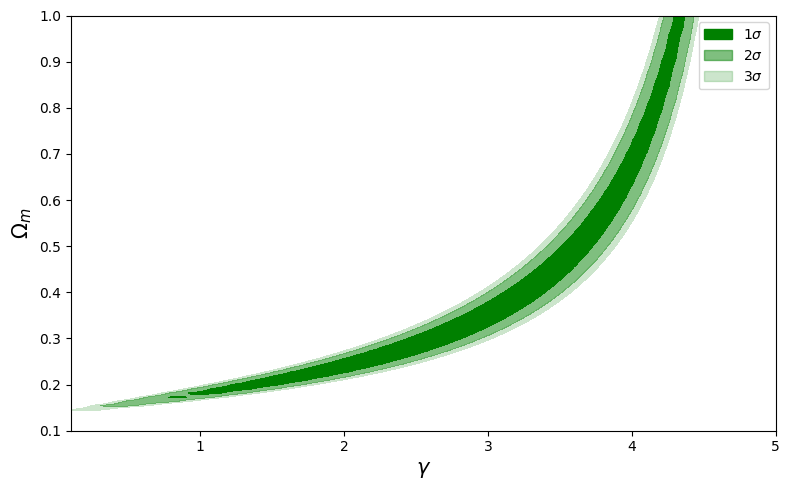

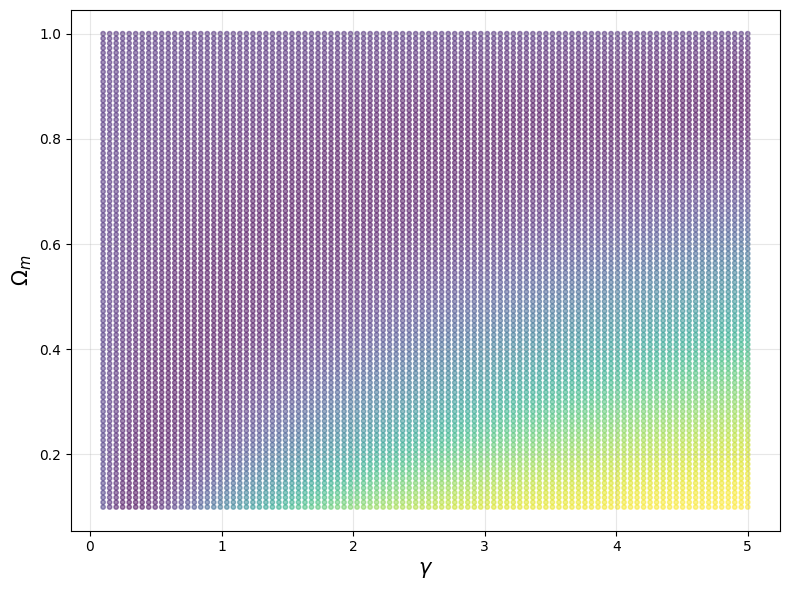

In [147]:
def calc_chi2_omega_gamma(omega_0, gamma_func):
    errors = 0.5 * (fs8_err_plus + fs8_err_minus)
    return np.sum((growth(z_data.values, gamma_func, omega_0) - fs8_data)**2 / errors**2)

# --- Paramètres de la grille ---
nb_points_distrib = 100
omega_m_list = np.linspace(0.1, 1, nb_points_distrib)
gamma_list = np.linspace(0.1, 5, nb_points_distrib)

# --- Calcul du chi2 sur la grille ---
chi2_grid = np.zeros((nb_points_distrib, nb_points_distrib))

for j, gamma_val in enumerate(gamma_list):
    for i, omegam in enumerate(omega_m_list):
        chi2_grid[i, j] = calc_chi2_omega_gamma(omegam, lambda x: gamma_val)

# --- Calcul de la vraisemblance jointe ---
delta_chi2_grid = chi2_grid - np.min(chi2_grid)



plt.figure(figsize=(8, 5))

plt.contourf(gamma_list, omega_m_list, delta_chi2_grid.T, levels=[0, levels[0]], colors=['green'], alpha=1.0)
plt.contourf(gamma_list, omega_m_list, delta_chi2_grid.T, levels=[levels[0], levels[1]], colors=['green'], alpha=0.5)
plt.contourf(gamma_list, omega_m_list, delta_chi2_grid.T, levels=[levels[1], levels[2]], colors=['green'], alpha=0.2)

patch1 = mpatches.Patch(color='green', alpha=1.0, label=r"1$\sigma$")
patch2 = mpatches.Patch(color='green', alpha=0.5, label=r"2$\sigma$")
patch3 = mpatches.Patch(color='green', alpha=0.2, label=r"3$\sigma$")

plt.xlabel(r"$\gamma$", fontsize=15)
plt.ylabel(r"$\Omega_m$", fontsize=15)
plt.grid(False)
plt.tight_layout()
plt.legend(handles=[patch1, patch2, patch3])
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(gamma_flat, omega_m_flat, c=delta_chi2_grid.flatten(), cmap='viridis', s=10, alpha=0.5)
plt.xlabel(r"$\gamma$", fontsize=15)
plt.ylabel(r"$\Omega_m$", fontsize=15)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
